## 罚函数

In [1]:
def set_step(k, opts):
    type_ = opts['step_type']
    if type_ == 'fixed':
        a = opts['alpha0']
    elif type_ == 'diminishing':
        a = opts['alpha0'] / np.sqrt(k)
    elif type_ == 'diminishing2':
        a = opts['alpha0'] / k
    else:
        print('unsupported type.')
    return a

opt = {'maxit': 2000, 'ftol': 0, 'step_type': 'fixed', 
       'alpha0': 0.01, 'thres': 1e-4}
def l1_subgrad(x0, A, b, mu, opts):
    for i in opt.keys():
        if opts.get(i, -1) == -1:
            opts[i] = opt[i]
    x = x0
    out = {'f_hist': np.zeros((opts['maxit'])), 
           'f_hist_best': np.zeros((opts['maxit'])), 
           'g_hist': np.zeros((opts['maxit']))}
    f_best = np.inf
    for k in range(1, opts['maxit']):
        r = np.matmul(A, x) - b
        g = np.matmul(A.T, r)
        out['g_hist'][k] = np.linalg.norm(r, 2)
        f_now = 0.5 * np.linalg.norm(r, 2) ** 2 + mu * np.linalg.norm(x, 1)
        out['f_hist'][k] = f_now
        f_best = min(f_best, f_now)
        out['f_hist_best'][k] = f_best
        if k > 1 and abs(out['f_hist_best'][k] - out['f_hist_best'][k-1]) / abs(out['f_hist_best'][1]) < opts['ftol']:
            break
        x[abs(x) < opts['thres']] = 0
        sub_g = g + mu * np.sign(x)
        alpha = set_step(k, opts)
        x = x - alpha * sub_g
    out['itr'] = k
    out['f_hist'] = out['f_hist'][1:k]
    out['f_hist_best'] = out['f_hist_best'][1:k]
    out['g_hist'] = out['g_hist'][1:k]
    return [x, out]

In [2]:
import numpy as np
import random
import scipy.sparse
random.seed(2)

m = 512
n = 1024
A = np.random.randn(m, n)
u = scipy.sparse.rand(n,1,0.1).toarray()
b = np.matmul(A, u)
x0 = np.zeros((n, 1))

In [3]:
opts = {'maxit': 600, 'alpha0': 0.0002, 'step_type':'fixed'}
x = x0
f_val = []
g_val = []
for mu in [10, 1, 1e-1, 1e-2, 1e-3]:
    [x, out] = l1_subgrad(x, A, b, mu, opts)
    f_val.extend(out['f_hist_best'][1:out['itr']] / mu)
    g_val.extend(out['g_hist'][1:out['itr']] / np.linalg.norm(b))

opts['maxit'] = len(f_val)+1
opts['ftol'] = 0
[x1, out] = l1_subgrad(x0, A, b, 1e-3, opts)
f_val1 = out['f_hist_best'] / 1e-3
g_val1 = out['g_hist'] / np.linalg.norm(b)

In [13]:
import matplotlib
 
font = {'family': 'MicroSoft Yahei',
       'weight': 'bold',
       'size': 12}
 
matplotlib.rc("font", **font)

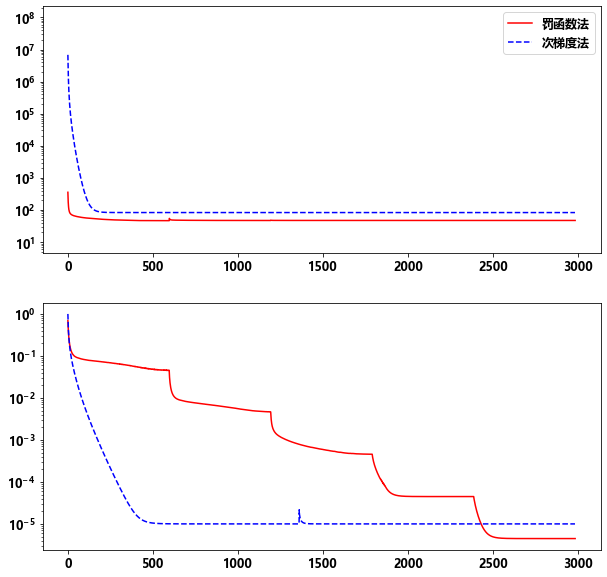

In [23]:
import matplotlib.pyplot as plt
x = list(range(len(f_val)))
y1=[pow(10,i) for i in range(1,9)]
x1=range(0, len(y1))
plt.figure(figsize=(10, 10)) 
plt.subplot(2,  1,  1)  
plt.plot(x1, y1, 'white')
plt.yscale('log')
plt.plot(x, f_val,'-', c='red', label = '罚函数法')
plt.plot(x[:-1], f_val1, '--',c='blue', label='次梯度法')
plt.legend()

plt.subplot(2,  1,  2)
y1=[pow(10,i) for i in range(-5,1)]
x1=range(0, len(y1))
plt.plot(x1, y1, 'white')
plt.yscale('log')
plt.plot(x, g_val,'-', c='red', label = '罚函数法')
plt.plot(x[:-1], g_val1, '--',c='blue', label='次梯度法')

plt.savefig('罚函数法')